In [90]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cf_xarray as cf
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shutil as shutil
from dask.distributed import Client
from scipy import ndimage
from skimage import measure
import pandas as pd
import plotly.express as px
import warnings

In [91]:
client = Client(threads_per_worker = 1)
catalog = intake.cat.access_nri

In [92]:
#setting the reference rho
rho_ref = 1035 #kg m^{-3}, used as standard by Pan-Antarctic
start_date='2000-01-01'
end_date = '2002-01-01'
experiment = "panant-01-zstar-ACCESSyr2"

In [93]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        elif variable == "siconc":
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "yB"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

In [95]:
#dxs in all grid points
dx_xhyh_01 =(1e-3* importer(experiment,catalog,"dxt")).compute()
dy_xhyh_01 =(1e-3* importer(experiment,catalog,"dyt")).compute()
#hipotenusa
Hyp = (dx_xhyh_01**2 + dy_xhyh_01**2)**0.5
deptho_01 =(1e-3* importer(experiment,catalog,"deptho").fillna(0)).compute()

In [96]:
from gsw import f as fcorr

model_lat = deptho_01.yh * (1 + deptho_01*0)
model_fcorr = fcorr(model_lat) #corilis parameter
model_fcorr_abs = (model_fcorr**2)**0.5
model_rossby = 1e-3*(((9.82*deptho_01*1e3))/model_fcorr_abs)**0.5

#lets locate where we can solve the rossby radius by separating all pointss where 2*dxt<rossby radius
dxt_2times = (2*dx_xhyh_01)
dxt_2times = (0*dxt_2times.where(dxt_2times<=model_rossby) +1)

#lets locate where we can solve the rossby radius by separating all pointss where 2*hyp<rossby radius
Hyp_2times = (2*Hyp )
Hyp_2times = (0*Hyp_2times.where(Hyp_2times<=model_rossby) +1)

In [97]:
#importing sea ice field
SICONC_005 = importer("panant-005-zstar-ACCESSyr2",catalog,"siconc",frequency='1mon',start_time='2000-01',end_time='2000-12')

MAX_SICONC = SICONC_005.max('time').compute()
MIN_SICONC = SICONC_005.min('time').compute()

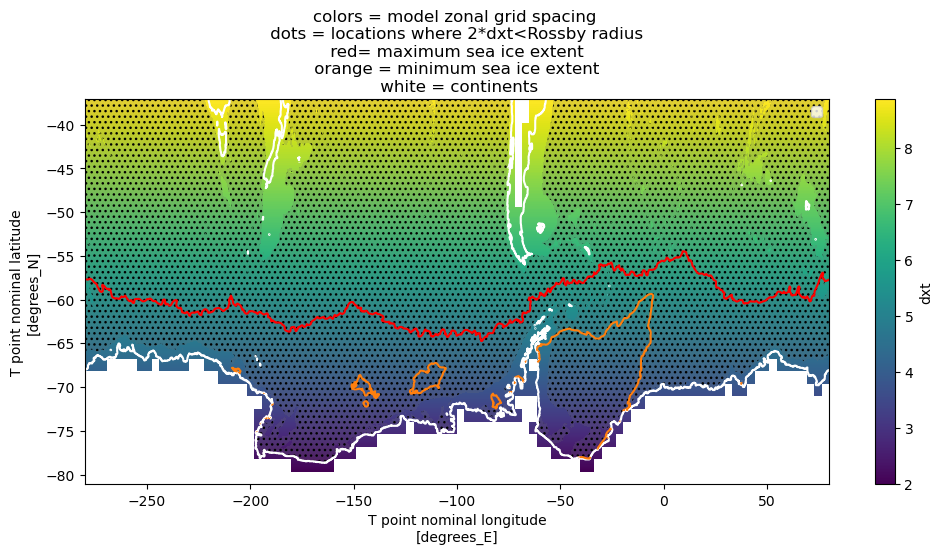

In [98]:
#fig case 1, dxt
fig, ax = plt.subplots(figsize=(12,5))
dx_xhyh_01.plot()
deptho_01.plot.contour(levels=[0],colors='w',label='continents')
MAX_SICONC.plot.contour(levels=[0.15,],colors='red',label='maximum sea ice extent')
MIN_SICONC.plot.contour(levels=[0.15,],colors='tab:orange',label='maximum sea ice extent')

cs = ax.contourf(dxt_2times.xh,dxt_2times.yh, dxt_2times, 
                 hatches=['...'], 
                 cmap='gray', 
                 extend='both', 
                 alpha=0.2)
plt.title('colors = model zonal grid spacing \n dots = locations where 2*dxt<Rossby radius \n red= maximum sea ice extent \n orange = minimum sea ice extent \n white = continents')
plt.legend()


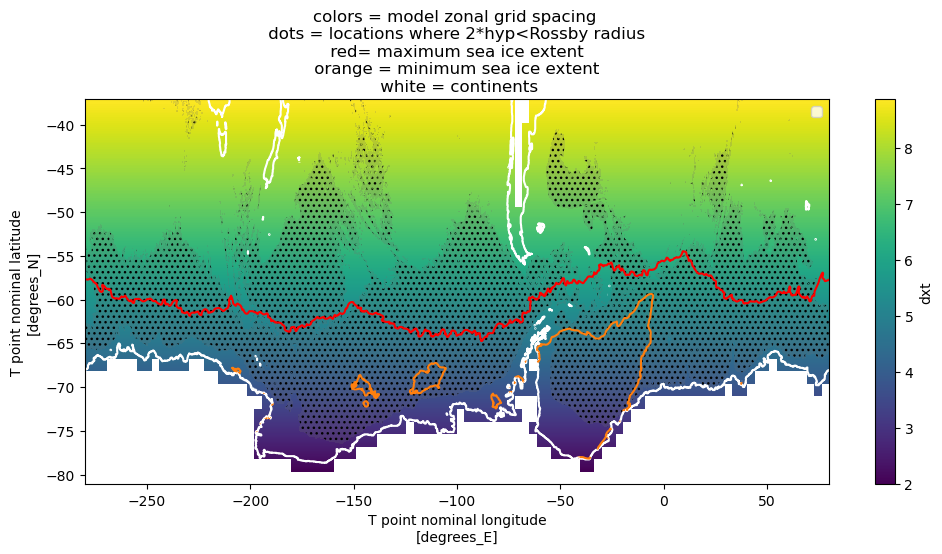

In [99]:
#fig case 2 hypotenuse
#fig case 1, dxt
fig, ax = plt.subplots(figsize=(12,5))
dx_xhyh_01.plot()
deptho_01.plot.contour(levels=[0],colors='w',label='continents')
MAX_SICONC.plot.contour(levels=[0.15,],colors='red',label='maximum sea ice extent')
MIN_SICONC.plot.contour(levels=[0.15,],colors='tab:orange',label='maximum sea ice extent')

cs = ax.contourf(Hyp_2times.xh,Hyp_2times.yh, Hyp_2times, 
                 hatches=['...'], 
                 cmap='gray', 
                 extend='both', 
                 alpha=0.2)
plt.title('colors = model zonal grid spacing \n dots = locations where 2*hyp<Rossby radius \n red= maximum sea ice extent \n orange = minimum sea ice extent \n white = continents')
plt.legend()


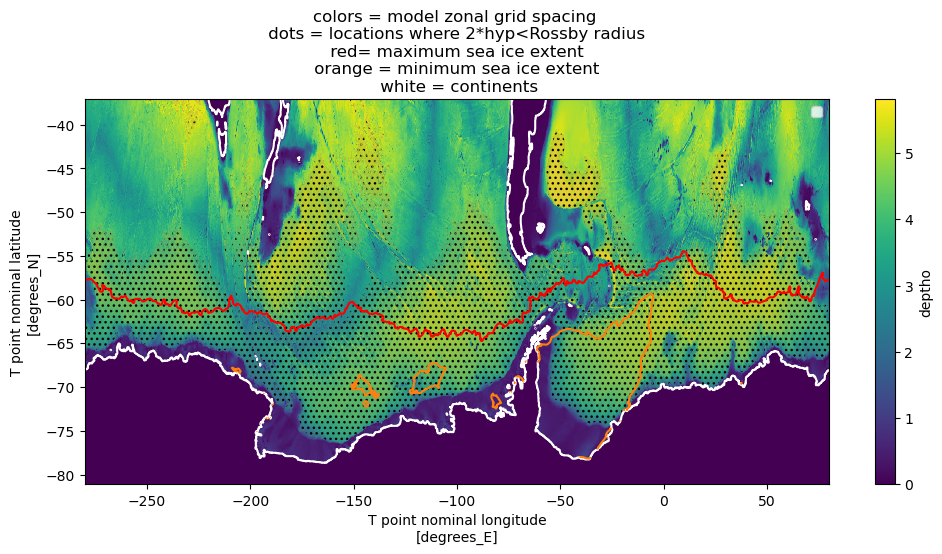

In [100]:
#fig case 2 hypotenuse
#fig case 1, dxt
fig, ax = plt.subplots(figsize=(12,5))
deptho_01.plot()
deptho_01.plot.contour(levels=[0],colors='w',label='continents')
MAX_SICONC.plot.contour(levels=[0.15,],colors='red',label='maximum sea ice extent')
MIN_SICONC.plot.contour(levels=[0.15,],colors='tab:orange',label='maximum sea ice extent')

cs = ax.contourf(Hyp_2times.xh,Hyp_2times.yh, Hyp_2times, 
                 hatches=['...'], 
                 cmap='gray', 
                 extend='both', 
                 alpha=0.2)
plt.title('colors = model zonal grid spacing \n dots = locations where 2*hyp<Rossby radius \n red= maximum sea ice extent \n orange = minimum sea ice extent \n white = continents')
plt.legend()